# YData Quality - Data drift Tutorial
Time-to-Value: 6 minutes

This notebook provides a tutorial for the ydata_quality package funcionality for drift analysis.

**Structure:**

1. Load dataset
2. Train and wrap example model
3. Distort dataset
4. Instantiate the Data Quality engine
5. Run the quality checks
6. Assess the warnings
7. (Extra) Detailed overview

In [1]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from ydata_quality.drift import DriftAnalyser, ModelWrapper

## Load the example dataset
We will use the wine dataset available from the sklearn package.

In [2]:
df = datasets.load_wine(as_frame=True)['frame']
df['target'] = df['target'].apply(str)  # Forcing categorical type inferral on target feat

## Train and wrap example model
We will train a simple classifier on the full dataset and wrap it with the ModelWrapper class just to demonstrate the engine's concept drift test.

In [3]:
# First we train a classifier
x = df.loc[:, df.columns != 'target']
y = df['target']
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x, y)

# Now we wrap it by directly instantiating the ModelWrapper class
wrapped_model = ModelWrapper(clf.predict)  # Note that we wrap the predict method of the trained classifier

## Distort the original dataset
Apply transformations to highlight the data quality functionalities.

In [4]:
def create_sample(df, frac=0.2):
    # Forge a sample
    sample = df.sample(frac=frac)
    # Distort sample values
    sample['alcohol'] = sample['alcohol'] + 5
    sample['target'] = '1'
    return sample

sample = create_sample(df)

## Create the engine
Each engine contains the checks and tests for each suite. To create a DriftAnalyser, you provide:
- ref: reference DataFrame, DataFrame that we will assume as the reference for the modelled population
- sample (optional): A test sample which we will compare against the reference. It should have the same schema as the reference dataframe, although the label column can always be optional for this sample (even when provided for the reference)
- label (optional): A string defining the label feature (will be searched for both in the reference and test samples)
- model (optional): A callable that inherits or directly instantiates ModelWrapper. This is supposed to wrap a label prediction model that consumes the provided sample covariates as input
- holdout_size (optional): A fraction defining the percentage of rows from the reference sample that are held-out for the reference tests. A 20% random subsample is taken by default.

In [5]:
da = DriftAnalyser(ref=df, sample=sample, label='target', model=wrapped_model)

### Full Evaluation
The easiest way to assess the data quality analysis is to run `.evaluate()` which returns a list of warnings for each quality check. 

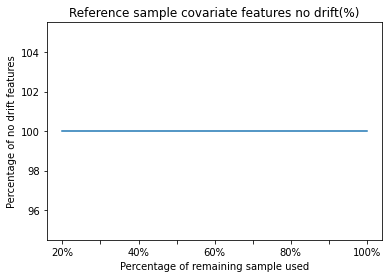

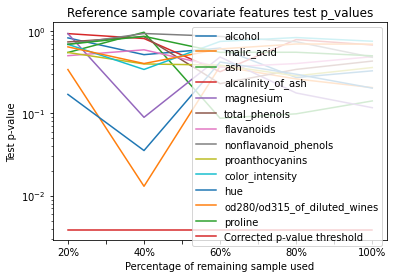

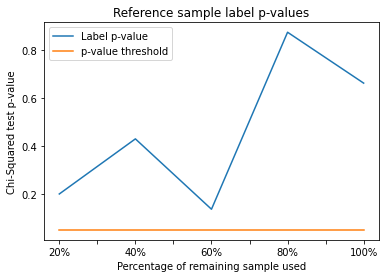

In [6]:
results = da.evaluate()

## Check the status
After running the data quality checks, you can check the warnings for each individual test. The warnings are suited by priority and have additional details that can provide better insights for Data Scientists.

In [7]:
da.report()

[SAMPLE LABEL DRIFT] The test was invalid. This is likely due to a small test sample size. (Priority 3: minor impact, aesthetic)
[SAMPLE COVARIATE DRIFT] 1 features accused drift in the sample test.

                    The covariates of the test sample do not appear to be representative of the reference sample. (Priority 2: usage allowed, limited human intelligibility)


### Quality Warning

In [8]:
# Get a sample warning
sample_warning = list(da.warnings)[0]

In [9]:
# Check the details
sample_warning.test, sample_warning.description, sample_warning.priority

('Sample label drift',
 'The test was invalid. This is likely due to a small test sample size.',
 <Priority.P3: 3>)

In [10]:
# Retrieve the relevant data from the warning
sample_warning_data = sample_warning.data

## Full Test Suite
In this section, you will find a detailed overview of the available tests in the sampling module of ydata_quality.

### Reference sample covariate drift

In this test we look for evidence of the reference sample covariates being representative of the underlying population.
A holdout is taken (20% by default), and increasing size random slices of data are taken from the leftover 80% data.
The leftover slices are tested against the holdout in attempt to provide drift evidence.

Due to limitations of this strategy we abstain to draw conclusions and instead only provide what we consider useful tools for the user to infer the healthiness of the reference sample.
An healthy indicator would be a monotonic increase of the percentage of features with no drift evidence and increasing individual p-values for the least performant tests, as the leftover slices are increased.

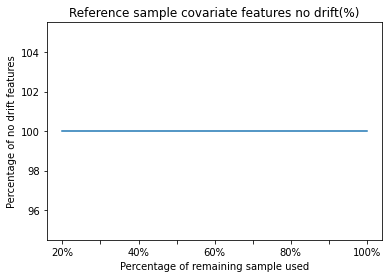

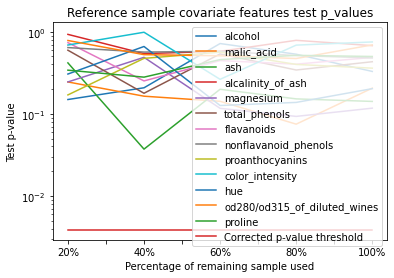

In [11]:
ref_cov_drift_out = da.ref_covariate_drift()

### Reference sample label drift

In this test we look for evidence of the reference sample labels being representative of the underlying population.
The same holdout and undersampling strategy from the previous test are used and, since now we have a univariate test, only the p-values for the increasing leftover slices are shown.

The results from this test are also simply indicative.

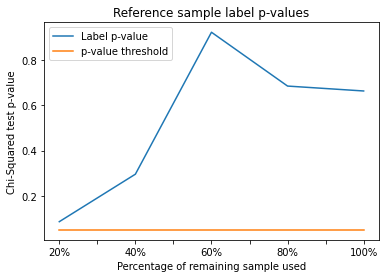

In [12]:
ref_label_drift_out = da.ref_label_drift()
# Here we notice the effects of changing all labels in the test sample to a fixed class

### Test sample covariate drift

In this test we look for evidence of the test sample covariates drifting from the reference sample.
The full reference sample is used in molding the distribution against which we test the test sample.

In the multivariate case, Bonferroni correction for the p-value is used in order to mitigate eventual false positives in the drift diagnosis.
If any feature from the covariates accuses drift, we raise a warning for the full sample.
In the case that no drift was detected, but there were failing tests, we will raise your attention with a lower priority warning and with recommendations (usually this is due to too small test samples).

In [13]:
sample_cov_drift_out = da.sample_covariate_drift()

In [14]:
sample_cov_drift_out
# As expected the corrupted alcohol feature is detected after the corruption step

,Statistic,Statistic Value,p-value,Verdict
alcohol,Kolmogorov-Smirnov,1.0,0.0,Drift
malic_acid,Kolmogorov-Smirnov,0.09176,0.939163,OK
ash,Kolmogorov-Smirnov,0.142322,0.526487,OK
alcalinity_of_ash,Kolmogorov-Smirnov,0.099251,0.895211,OK
magnesium,Kolmogorov-Smirnov,0.110175,0.814092,OK
total_phenols,Kolmogorov-Smirnov,0.11392,0.785382,OK
flavanoids,Kolmogorov-Smirnov,0.146692,0.490834,OK
nonflavanoid_phenols,Kolmogorov-Smirnov,0.12578,0.677276,OK
proanthocyanins,Kolmogorov-Smirnov,0.084582,0.968732,OK
color_intensity,Kolmogorov-Smirnov,0.161985,0.366752,OK


### Test sample label drift

In this test we look for evidence of the test sample label drifting from the reference sample.
The same strategy from the previous step applies.
If the label accuses drift, we raise a warning for the test sample.
In the case that no drift was detected, but there was a failing test, we will raise your attention with a lower priority warning and a recommendation (usually this is due to too small test samples).

In [15]:
sample_label_drift_out = da.sample_label_drift()

### Test concept drift

In this test we look for evidence of concept drift.
If the provided model produces output for the test sample which appears not to be representative of the output generated from the reference sample, concept drift is detected.

In [16]:
sample_concept_drift_out = da.sample_concept_drift()
